Import Dependencies

In [1]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from scipy.signal import find_peaks
from pathlib import Path
import stumpy



User Inputs

In [2]:
BD = 2 #Bluedrop file is from 
fileNum = '0021' # write the bin file number you want to analyze (do not include 'bLog' or '.bin')
soiltype = "s" #s = sand, c=clay, m=mixed, u=unknown
atype = 'm'  # m = mantle area (best for sands), p = projected area (best for clays)
tiptype = 'c'  # c = cone, p = parabolic, b = blunt
#offset = 1 # this value is subtracted from the accelerometer readings
droptype = 'a' #w = water, #a = air
sign = "uk" #enter an effective unit weight value in kg/m^3 or "uk" if unknown 
# paste the filepath to the folder where the BD data is stored
binFilepath = Path("H:/.shortcut-targets-by-id/1aF9t2aiRGWTftJMZFAOBixqvQniFBjnb/Duck  2023/Data/Intertidal/BlueDrop, Samples & Moisture Gage/07March23/BD2 3.7.23 - Drops Only")


Set the penetrometer information and bring in Timeseries Data

In [4]:
def masslength(tiptype): #sets the mass and length of the pentrometer based on the tip
    global mass
    global length
    if tiptype == 'c':
        mass = 7.71 #kg
        length = 8.48-0.93 #originally 7.87, 7.57 for perfect 60 deg, 8.48 measured - .93 measured 90 deg
    elif tiptype == 'p':
        mass = 9.15
        length = 8.26
    elif tiptype == 'b':
        mass = 10.30
        length = 8.57

masslength(tiptype)

# READ BD DATA IN
data_array = []  # creates an empty array for us to fill with bd data
fileName = 'bLog'+fileNum+".bin"
# print(fileName)
newPath = binFilepath / fileName
#print(newPath)
file = open(newPath, 'rb')  # read file
element = file.read(3)  # create a byte list with each element having 3 bytes

while element:
    # Convert to signed integer before adding to data array
    iVAl = int.from_bytes(element, byteorder='big', signed=True)
    data_array.append(iVAl)  # adds the reshaped data from the bd file to the data frame
    element = file.read(3)

np_array = np.array(data_array)  # create numpy array from the list
np_array = np.reshape(np_array, (-1, 10))  # convert the 1d array to 2d array with 10 cols

df = pd.DataFrame(np_array) # Creates a Dataframe in pandas from the bd data
df.columns = ['Count', 'no clue', 'g2g', 'g18g', 'g50g', 'ppm', 'g200g', 'gX55g', 'gY55g', 'g250g'] # names columns
# print(dfCal)

Calibrate

In [5]:
# APPLY CALIBRATION FACTORS
if BD == 3:  # calibration factors from March 2023
    g2g = (df['g2g']-33570.1)/1614577.9 #- offset# accelerometers are in g
    g18g = (df['g18g']+13495)/163387.2 #- offset
    g50g = (df['g50g']-238817.4)/63779.5 #- offset
    ppm = ((df['ppm']-139040.1)/20705) * 6.89475729 # converts to kPa
    g200g = (df['g200g'] -262332.4)/38888.7 #- offset
    gX55g = (df['gX55g']-70406)/59754.3
    gY55g = (df['gY55g']-69421.1)/141871.5
    g250g = (df['g250g']-39077.4)/13746.9 #- offset

if BD == 2: # calibration factors from March 2023
    g2g = (df['g2g']+36597.6)/1637627.3 #- offset# accelerometers are in g
    g18g = (df['g18g']-26185.3)/160297.2 #- offset
    g50g = (df['g50g']-212256.9)/63968.7 #- offset
    ppm = ((df['ppm']+55518.9)/18981.7) * 6.89475729 # converts to kPa
    g200g = (df['g200g']-175499.4)/30583.8 #- offset
    gX55g = (df['gX55g']-53629.9)/68590.9
    gY55g = (df['gY55g']-43694.3)/68280.3
    g250g = (df['g250g']-39619.9)/13545.8 #- offset

if BD == 1: # calibration factors from March 2023
    g2g = (df['g2g']-43727.6)/1625064 #- offset # accelerometers are in g
    g18g = (df['g18g']-45085.6)/160925.7 #- offset
    g50g = (df['g50g']-173493.4)/63944.6 #- offset
    ppm = ((df['ppm']+31776.1)/20679.7) * 6.89475729 # this is kPa
    g200g = (df['g200g'] -731734.3)/32192.4  #- offset
    gX55g = (df['gX55g'] -68837.9)/52137.3
    gY55g = (df['gY55g']-68015.9)/28074.9
    g250g = (df['g250g']+10580)/13688.7 #- offset

time = (df['Count']-df['Count'].iloc[0]+1)/2000 # gives time in s
count = df["Count"]-df['Count'].iloc[0]

# make a new dataframe of the calibrated values in units of g
dfCalg = pd.DataFrame([count, time, g2g, g18g, g50g, g200g, g250g, gX55g, gY55g, ppm])
dfCalg = dfCalg.T
dfCalg.columns = ['Count', 'Time (s)', '2g (g)', '18g (g)', '50g (g)', '200g (g)', '250g (g)', 'X55g (g)', 'Y55g (g)', 'Pore Pressure (kPa)']  # names columns
#print(dfCalg)

#make a new dataframe of the calibrated values in units of m/s^2
dfCal = pd.DataFrame([count, time, g2g, g18g, g50g, g200g, g250g, gX55g, gY55g, ppm])
dfCal = dfCal.T
dfCal.columns = ['Count','Time (s)', '2g (m/s^2)', '18g (m/s^2)', '50g (m/s^2)', '200g (m/s^2)', '250g (m/s^2)', 'X55g (m/s^2)', 'Y55g (m/s^2)', 'Pore Pressure (kPa)']  # names columns
dfCal['2g (m/s^2)'] = dfCal['2g (m/s^2)'] * 9.80665
dfCal['18g (m/s^2)'] = dfCal['18g (m/s^2)'] * 9.80665
dfCal['50g (m/s^2)'] = dfCal['50g (m/s^2)'] * 9.80665
dfCal['200g (m/s^2)'] = dfCal['200g (m/s^2)'] * 9.80665
dfCal['250g (m/s^2)'] = dfCal['250g (m/s^2)'] * 9.80665
dfCal['X55g (m/s^2)'] = dfCal['X55g (m/s^2)'] * 9.80665
dfCal['Y55g (m/s^2)'] = dfCal['Y55g (m/s^2)'] * 9.80665
#print(dfCal)

Locate all drops, zoom into first one

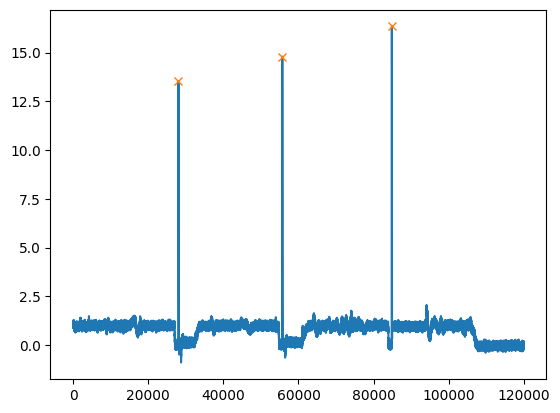

In [6]:
#Locate the drops
x = np.array(g250g)  # what accelerometer to get the peaks from - use 250 because it will never be maxed out
max250 = max(g250g)

peaks, _ = find_peaks(x, height = 2, distance=1000, prominence=3)  # finds the largest peaks more than 2g spaced at least 10000 counts apart

peaksArray = np.array(peaks)  # prints a list of the count where the peaks occur
#peaksArray = filter(filterpeak, peaksArray)

#print(peaksArray)
q = (peaksArray.shape) #gives number of peaks
nDrops = int(q[0]) #number of drops in the file
#print(nDrops)

# For each drop, find the start and end points and integrate to solve for velocity and acceleration
#peakplot()

def peakplot(): # Plot showing peak deceleration
    peakplot = plt.plot(x)
    peakplot = plt.plot(peaks, x[peaks], "x")
    plt.show()

peakplot()
#overviewplot()

Zoom into drop of interest

In [7]:
a = 1 #what drop do you want to analyze? USER INPUT
a = a-1

peak = int(peaksArray[a])  # count at the ath drop
print("peak index:" , peak)

def dropstartend(peak): #after locating the peaks, this function chops the minute long file into a smaller segment immediately before and after the peak
    global dropstart
    global dropend
    if peak <= 1500:
        dropstart = 1
        dropend = peak + 500
    elif peak > 119500:
        dropstart = peak - 1500
        dropend = 120000
    else:
        dropstart = peak - 1500
        dropend = peak + 500

def accPick(dg, d): #this function picks the smallest accelerometer that's not maxed out to perform the integration on
    maxAcc = dg["250g (g)"].max()
    global acc
    global accName
    global accNameg
    global accg
    if maxAcc < 5: #- offset:
        if dg["2g (g)"].max() < 1.8: #offset:  # does an extra check for the 2g because of noise
            acc = dfCal["2g (m/s^2)"]
            accg = dfCalg["2g (g)"]
            accName = "2g (m/s^2)"
            accNameg = "2g (g)"
        else:
            acc = dfCal["18g (m/s^2)"]
            accg = dfCalg["18g (g)"]
            accName = "18g (m/s^2)"
            accNameg = "18g (g)"
    elif maxAcc < 18: #- offset
        acc = dfCal["18g (m/s^2)"]
        accg = dfCalg["18g (g)"]
        accName = "18g (m/s^2)"
        accNameg = "18g (g)"
    elif maxAcc < 50: #- offset:
        acc = dfCal["50g (m/s^2)"]
        accg = dfCalg["50g (g)"]
        accName = "50g (m/s^2)"
        accNameg = "50g (g)"
    else:
        acc = dfCal["250g (m/s^2)"]
        accg = dfCalg["50g (g)"]
        accName = "250g (m/s^2)"
        accNameg = "250g (g)"
                
dropstartend(peak) #zooms in the drop file to only consider 500 counts before and 1500 counts after the peak deceleration
#print(dropstart, dropend)

drop1 = dfCal[dropstart:dropend]  # start and end points of the drop in m/s^2
drop1g = dfCalg[dropstart:dropend]  # start and end points of the drop in g
drop1 = pd.DataFrame(drop1)  # makes dataframe including all data within the start and end points of the drop
drop1g = pd.DataFrame(drop1g)
dg = drop1g 
d = drop1
accPick(dg, d)  # chooses what accelerometer to use
acc1 = acc
acc1g = accg
acc1Name = accName
acc1Nameg = accNameg
#findchangepts() #automatically identifies the moment of penetration


peak index: 28061


matrix profile

The motif is located at index 1653
The nearest neighbor is located at index 1680
The discord is located at index 1337
The nearest neighbor subsequence to this discord is 12.079028791387648 units away


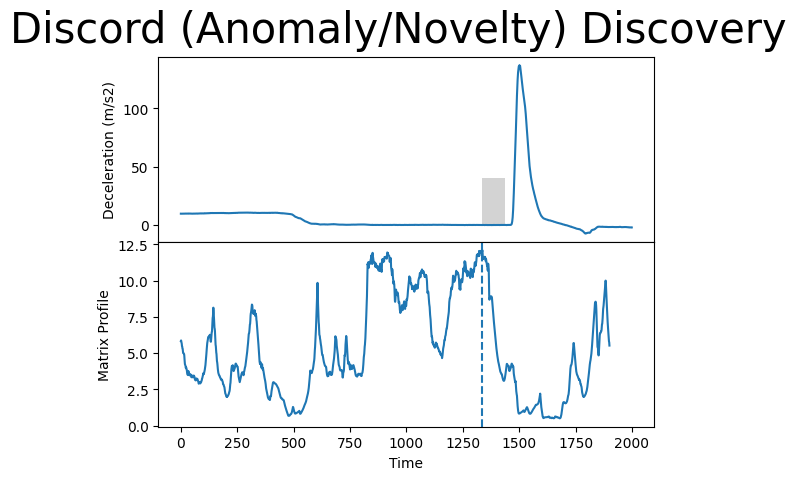

In [20]:
#create matrix profile
m = 100
mp = stumpy.stump(drop1[acc1Name], m)

#find motif, discord and nearest neighbors
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")
nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

discord_idx = np.argsort(mp[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")
nearest_neighbor_distance = mp[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

#plot time series and MP
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(drop1[acc1Name].values)
axs[0].set_ylabel('Deceleration (m/s2)', fontsize='10')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='10')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

Find optimal window size

[1130, 1112, 1055, 934, 1337, 1314, 883, 864, 850, 831]


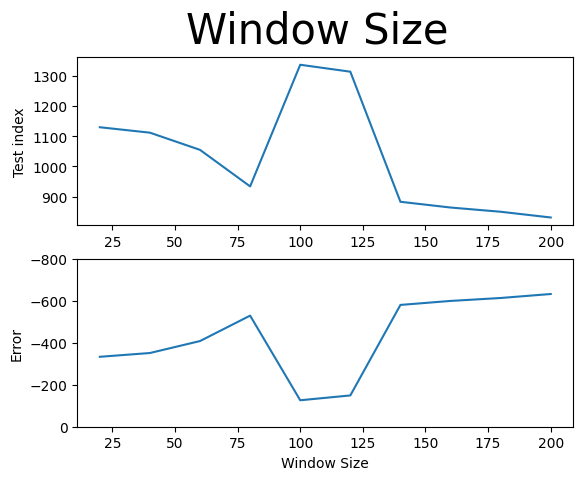

In [21]:
m_test_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
discord_test_idx = []
for i in range(0,len(m_test_sizes)):
    m = m_test_sizes[i]
    mp = stumpy.stump(drop1[acc1Name], m)
    discord_idx = np.argsort(mp[:, 0])[-1]
    discord_test_idx.append(discord_idx)

print(discord_test_idx)

discord_test_idx = np.array(discord_test_idx)

peak_idx = 28061
start_file = 28061 - 1500
true_index = 28024 - start_file

error = discord_test_idx - true_index

#plot error vs m
fig, axs = plt.subplots(2) #sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Window Size', fontsize='30')

axs[0].plot(m_test_sizes, discord_test_idx)
axs[0].set_ylabel('Test index', fontsize='10')
axs[1].plot(m_test_sizes, error)
axs[1].set_xlabel('Window Size', fontsize ='10')
axs[1].set_ylabel('Error', fontsize='10')
axs[1].set_ylim(0,-800)

plt.show()


